<a href="https://colab.research.google.com/github/Monoxido45/Active_learning_tests/blob/master/modules/reg_ativa_exemplos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplos e simulações iniciais para nosso metodo de regressão ativa

In [3]:
# pacotes
# pacotes importados
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
# instalando modAL
from sklearn.model_selection import train_test_split
!pip install modAL
import modAL


# pacotes que serao usados
from sklearn.metrics import mean_squared_error
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Lasso
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import DotProduct

# montando o colab
from google.colab import drive
drive.mount('/content/drive')
images_dir = '/content/drive/MyDrive/Colab Notebooks/active_learning/figuras'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Todas funções que estão sendo utilizadas

In [4]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
!pip install modAL
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modAL import ActiveLearner
from sklearn.base import clone
import numpy as np
import modAL
from sklearn.metrics import mean_squared_error
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling


# funcoes das simulacoes
# simulacao 1
def reg_lin(n = 1200, beta_0 = 1, beta_1 = 0.75, seed = 1500, scale = 0.25):
  np.random.seed(seed)
  X = np.random.uniform(low = 0, high = 4, size = n)
  y = beta_0 + beta_1 * X + np.random.normal(loc = 0, scale = scale, size = n)

  return [X, y]

# simulacao 2
def reg_ex2(n = 200, beta_0 = 1, beta_1 = 0.75, seed = 1050, scale = 0.15):
  np.random.seed(seed)
  X = np.random.uniform(low = 0, high = 4, size = n)
  y = beta_0 + beta_1 * X + 2*(np.sin(X)**2) + np.random.normal(loc = 0, scale = 0.15, size = n)
  return [X, y]

# simulacao 3
def reg_ex3(n = 200, beta_0 = 1, beta_1 = 0.75, random_seed = 1200):
  X = np.random.uniform(low=0, high = 4, size = n)
  y = beta_0 + beta_1 * X + 2*(np.sin(X)**2) + np.random.normal(loc = 0, 
                                                                scale = np.round(X, decimals = 1)/4, size = n)
  return [X,y]

# funcao que adiciona ruido na pool e treino
def add_noise(X, nfeatures = 30, sd = 0.5, mu = 2, seed = 250):
  np.random.seed(seed)
  noise_mat = np.random.normal(size = (X.shape[0], nfeatures), loc = mu, scale = sd)
  return np.hstack((X, noise_mat))

# metodos para o AL
def bias_reduction(regressor, X, valid_regressor = KNeighborsRegressor(), k = 2, random_state = 99):
  # splitting into two folds:
  kf = KFold(n_splits = k, random_state = random_state, shuffle = True)
  # obtaining labeled data by regressor
  X_labeled, y_labeled = regressor.X_training, regressor.y_training

  errors = np.zeros((X.shape[0], k))
  # K-fold loop
  i = 0
  for train_idx, test_idx in kf.split(X_labeled):
    X_train, X_test = X_labeled[train_idx], X_labeled[test_idx]
    y_train, y_test = y_labeled[train_idx], y_labeled[test_idx]
    # first, fitting the current training data
    # cloning regressor
    # caso de comite
    if type(regressor.estimator) == modAL.models.learners.CommitteeRegressor:
      train_learner = regressor.estimator
      train_learner.teach(X_train, y_train, only_new = True)
    else:
      train_learner = clone(regressor.estimator)
      train_learner.fit(X = X_train, y = y_train)

    # now obtaining Z
    z = (y_test - train_learner.predict(X_test))**2

    # fitting the regression on z
    valid_learner = clone(valid_regressor)
    valid_learner.fit(X = X_test, y = z)

    # now obtaining the errors for each observation in the pool
    errors[:, i] = valid_learner.predict(X)
    i += 1
  
  # obtaining scores by computing the row-wise means of errors
  scores = errors.mean(axis=1)

  # sorting index in descending order
  ranked = np.argsort(scores)
  query_idx = ranked[::-1][0]

  # finally returning the index
  return query_idx, X[query_idx]


# definindo uma estrategia aleatoria
def random_sampling(regressor, X_pool):
  n_samples = len(X_pool)
  query_idx = np.random.choice(range(n_samples))
  return query_idx, X_pool[query_idx]

# definindo o uncertainty sampling para regressao
def uncertainty_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]


# laco da modelagem
def laco_modelo(n_queries, modelo, X_pool, y_pool, X_test, y_test, 
                trace = False, col = None, s = None, index = None, **fit_kwargs):
  list_mse = [mean_squared_error(y_test, modelo.predict(X_test))]
  X_pool_c, y_pool_c = np.copy(X_pool), np.copy(y_pool)

  # lasso do aprendizado ativo:
  for i in range(n_queries):
    query_idx, query_instance = modelo.query(X_pool_c, **fit_kwargs)
    X_sel, y_sel = X_pool_c[query_idx].reshape(1, -1), y_pool_c[query_idx].reshape(1, )
    modelo.teach(X = X_sel, y = y_sel)
    X_pool_c, y_pool_c = np.delete(X_pool_c, query_idx, axis=0), np.delete(y_pool_c, query_idx)
    if (trace):
      col[index[query_idx]] = 'green'
      s[index[query_idx]] = 50
      index = np.delete(index, query_idx)
    list_mse.append(mean_squared_error(y_test, modelo.predict(X_test)))
  if (trace):
    return [list_mse, col, s]
  return list_mse


def prepare_train(X_pool, y_pool, n_initial = 10, colorize = False, seed = 700):
  X_pool_c, y_pool_c = np.copy(X_pool), np.copy(y_pool)
  np.random.seed(seed)
  # amostrando aleatoriamente sem reposicao
  train_idx = np.random.choice(range(X_pool_c.shape[0]),
    size = n_initial, replace = False)
  X_train = X_pool_c[train_idx]
  y_train = y_pool_c[train_idx]
  dict_al = {}
  if colorize:
    s = []
    col = []
    index = np.arange(0, X_pool_c.shape[0])
    for i in range(0, X_pool_c.shape[0]):
      if i in train_idx:
        col.append('red')
        s.append(50)
      else:
        col.append('black')
        s.append(20)
    index = np.delete(index, train_idx)
    dict_al = {"size" : s, "color" : col,"index" : index}

  # reduzindo a pool
  X_pool_c = np.delete(X_pool_c, train_idx, axis=0)
  y_pool_c = np.delete(y_pool_c, train_idx)
  dict_al["X_pool"], dict_al["y_pool"] = X_pool_c, y_pool_c
  dict_al["X_train"], dict_al["y_train"] = X_train, y_train
  return(dict_al)



def mse_comb(n_queries, X_train, y_train, X_pool, y_pool,
             X_test, y_test, mods_list):
  comb_grid = np.array(np.meshgrid(mods_list, mods_list)).T.reshape(-1, 2)
  dici_mse = dict()
  model_list = []

  for comb in comb_grid:
    reg_mod = ActiveLearner(estimator = comb[0],
                     query_strategy = bias_reduction,
                     X_training = X_train, y_training = y_train)
    
    list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test, 
                          valid_regressor = comb[1])
    # string da combinacao
    str1 = ''.join([c for c in str(comb[0]) if c.isupper()])
    str2 = ''.join([c for c in str(comb[1]) if c.isupper()])

    if comb[0] not in model_list:
      reg_mod_random = ActiveLearner(estimator = comb[0],
                     query_strategy = random_sampling,
                     X_training = X_train, y_training = y_train)
      
      list_rand = laco_modelo(n_queries, reg_mod_random, 
                          X_pool, y_pool, X_test, y_test)
      
      model_list.append(comb[0])
      dici_mse[str1 + " " + "Random"] = list_rand
      
    dici_mse[str1 + " " + str2] = list_mse

    
    if comb[0] not in model_list:
      reg_mod_random = ActiveLearner(estimator = comb[0],
                     query_strategy = random_sampling,
                     X_training = X_train, y_training = y_train)
      
      list_rand = laco_modelo(n_queries, reg_mod_random, 
                          X_pool, y_pool, X_test, y_test)
      
      model_list.append(comb[0])
      dici_mse[str1 + " " + "Random"] = list_rand

  return(dici_mse)

def gera_semente(seed = 650, reps = 10):
  np.random.seed(seed)
  return(np.random.choice(np.arange(0, 1000), reps))

def create_sim_data(dici_mods):
  create = True
  for key in dici_mods.keys():
    mod_string = key.split(" ")
    if mod_string[1] == 'Random':
      if create:
        df_final = pd.DataFrame({"score" : np.tile(dici_mods[key], 3),
                      "consulta" : np.tile(np.arange(0, len(dici_mods[key])), 3),
                      "ajuste" : np.tile(mod_string[0], 3*len(dici_mods[key])),
                      "metodo": np.tile("Random", 3*len(dici_mods[key]))}
                    )
        create = False
      else:
        df_temp = pd.DataFrame({"score" : np.tile(dici_mods[key], 3),
                      "consulta" : np.tile(np.arange(0, len(dici_mods[key])), 3),
                      "ajuste" : np.tile(mod_string[0], 3*len(dici_mods[key])),
                      "metodo": np.tile("Random", 3*len(dici_mods[key]))}
                    )
        df_final = df_final.append(df_temp, ignore_index = True)
    else:
      df_temp = pd.DataFrame({"score" : dici_mods[key],
                             "consulta" : np.arange(0, len(dici_mods[key])),
                             "ajuste" : mod_string[0],
                              "metodo": np.tile("Redução de viés" + " (" + mod_string[1] + ")", len(dici_mods[key]))}
                             )
      df_final = df_final.append(df_temp, ignore_index = True)
  df_final = df_final.replace({"KNR": "KNN", "RFR": "RF"}, regex = True)
  return df_final


def laco_experimento_random(n_amostra, seed_amostras, seed_processo, func_sim, mods_list, n_queries = 30,
                            add_noise = False):
  X_ex, y_ex = func_sim()
  if(add_noise):
    X_ex = add_noise(X_ex.reshape(-1, 1))
    X_pool_ex, X_test_ex, y_pool_ex, y_test_ex = train_test_split(X_ex, 
                                                                  y_ex, 
                                                                  test_size = 0.2, 
                                                                  random_state=42)
  else:
    X_pool_ex, X_test_ex, y_pool_ex, y_test_ex = train_test_split(X_ex.reshape(-1, 1), 
                                                                y_ex, 
                                                                test_size = 0.2, 
                                                                random_state=42)
  # gerando amostras de treino
  amostras = []
  sementes = gera_semente(seed = seed_amostras, reps = n_amostra)
  for i in range(len(sementes)):
    amostras.append(prepare_train(X_pool_ex, y_pool_ex, seed = sementes[i]))
  np.random.seed(seed_processo)

  # obtendo resultados de AL para cada amostra
  dfs = []
  for i in range(n_amostra):
    dici_conj = amostras[i]
    dici_ex = (mse_comb(n_queries = n_queries, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test_ex, 
                    y_test = y_test_ex, 
                    mods_list = mods_list))
    temp_data = create_sim_data(dici_ex)
    temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
    dfs.append(temp_data)
  df = pd.concat(dfs, axis=0, ignore_index=True)
  # sim_ex2 = create_sim_data(dici_ex2)
  sim_ex = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'ajuste': 'first', 'metodo': 'first'})
  return sim_ex

# plotando simulação na comparação com amostragem aleatória
def plot_sim_random(sim_data, path):
  plt.figure(figsize = (12, 8))
  g = sns.FacetGrid(sim_data, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
  g.map(sns.lineplot, "consulta", "score")
  g.figure.subplots_adjust(wspace=0, hspace=0)
  g.add_legend()
  plt.tight_layout()
  plt.savefig(path)

# Exemplinhos iniciais

Simulando dados de uma regressão linear apenas para testar se funciona a implementação do método pelo modAL:

In [5]:
# gerando os X's
np.random.seed(1500)
n = 1200
X = np.random.uniform(low=0, high = 4, size = n)

# gerando os y por uma regressao linear
beta_0 = 1
beta_1 = 0.75
y = beta_0 + beta_1 * X + np.random.normal(loc = 0, scale = 0.25, size = n)

sim_data_lin = pd.DataFrame(data = {'X' : X,
                                'Y' : y})

In [6]:
X_lin, y_lin = reg_lin(1200, beta_0, beta_1, 1500, 0.25)

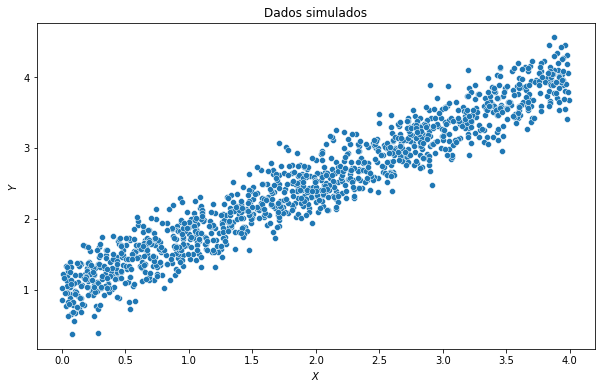

In [7]:
plt.figure(figsize = (10,6))
sns.scatterplot(data = sim_data_lin, x = "X", y = "Y", color = "tab:blue")
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados simulados")
plt.savefig(f"{images_dir}/reg_lin_sim_data.pdf")
plt.show()

Dividindo em treino e teste e pegando apenas 5 pontos iniciais para treinamento:

In [8]:
from sklearn.model_selection import train_test_split
# teste para ver desempenho depois
X_pool_lin, X_test_lin, y_pool_lin, y_test_lin = train_test_split(X.reshape(-1, 1), y, test_size = 0.2, random_state=42)

# setando as amostras iniciais:
np.random.seed(2018)
# 20 de treinamento inicial
n_initial = 10
train_idx = np.random.choice(range(X_pool_lin.shape[0]), size = n_initial, replace = False)
X_train_lin = X_pool_lin[train_idx]
y_train_lin = y_pool_lin[train_idx]

# reduzindo a pool
X_pool_lin = np.delete(X_pool_lin, train_idx, axis=0)
y_pool_lin = np.delete(y_pool_lin, train_idx)

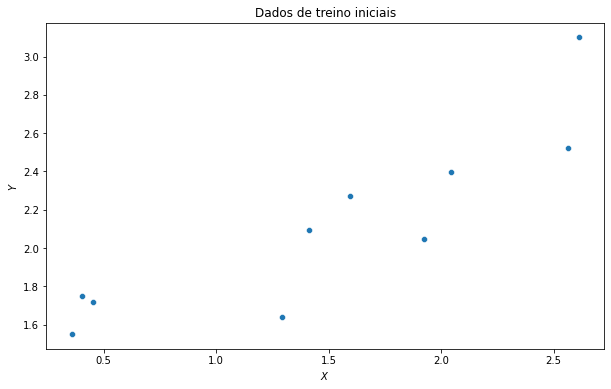

In [9]:
sns.set_palette("Set1")
plt.figure(figsize = (10,6))
sns.scatterplot(x = X_train_lin.ravel(), y = y_train_lin, color = "tab:blue")
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados de treino iniciais")
plt.savefig(f"{images_dir}/reg_lin_train_sim_data.pdf")

Testando por hora no exemplo simples essa estratégia e vendo se funciona

In [10]:
# initializing learners
from sklearn.linear_model import LinearRegression

reg_mod = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = bias_reduction,
                     X_training = X_train_lin, y_training = y_train_lin)

reg_mod_random = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = random_sampling,
                     X_training = X_train_lin, y_training = y_train_lin)

In [11]:
reg_mod.teach(np.array([[1]]), np.array([2]))
reg_mod.X_training

array([[1.41387219],
       [1.29195736],
       [2.04374148],
       [1.92516288],
       [0.40299212],
       [0.35801163],
       [2.61204028],
       [1.59444105],
       [0.45301883],
       [2.56495919],
       [1.        ]])

In [12]:
reg_mod = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = bias_reduction,
                     X_training = X_train_lin, y_training = y_train_lin)
reg_mod.X_training

array([[1.41387219],
       [1.29195736],
       [2.04374148],
       [1.92516288],
       [0.40299212],
       [0.35801163],
       [2.61204028],
       [1.59444105],
       [0.45301883],
       [2.56495919]])

Analisando o comportamento dessa estratégia e comparando depois com a amostragem aleatória:

In [13]:
from sklearn.metrics import mean_squared_error
n_queries = 30
np.random.seed(1500)
list_mse_br = laco_modelo(n_queries, reg_mod, 
                          X_pool_lin, y_pool_lin, X_test_lin, y_test_lin, 
                          valid_regressor = KNeighborsRegressor())

list_mse_rand = laco_modelo(n_queries, reg_mod_random, 
                            X_pool_lin, y_pool_lin, X_test_lin, y_test_lin)

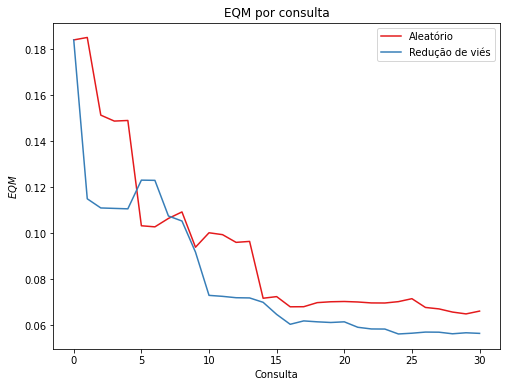

In [14]:
queries = np.arange(0, n_queries + 1)
plt.figure(figsize = (8, 6))
plt.plot(queries, np.array(list_mse_rand), label = "Aleatório")
plt.plot(queries, np.array(list_mse_br), label = "Redução de viés")
plt.xlabel(r"Consulta")
plt.ylabel(r"$EQM$")
plt.title("EQM por consulta")
plt.legend()
plt.savefig(f"{images_dir}/eqm_por_consulta_reg_lin.pdf")
plt.show()

Experimento proposto pelo professor:

In [15]:
# gerando de uma regressao nao linear
np.random.seed(1050)
n = 200
X = np.random.uniform(low=0, high = 4, size = n)

# gerando os y por uma regressao linear
beta_0 = 1
beta_1 = 0.75
y = beta_0 + beta_1 * X + 2*(np.sin(X)**2) + np.random.normal(loc = 0, scale = 0.15, size = n)

def reg_ex2(n = 200,beta_0 = 1, beta_1 = 0.75, seed = 1050, scale = 0.15):
  np.random.seed(seed)
  X = np.random.uniform(low = 0, high = 4, size = n)
  y = beta_0 + beta_1 * X + 2*(np.sin(X)**2) + np.random.normal(loc = 0, scale = 0.15, size = n)
  return [X, y]

# teste para ver desempenho depois
X_pool_ex2, X_test_ex2, y_pool_ex2, y_test_ex2 = train_test_split(X.reshape(-1, 1), y, test_size = 0.3, random_state=42)

sim_data = pd.DataFrame(data = {'X' : X_pool_ex2.ravel(),
                                'Y' : y_pool_ex2})

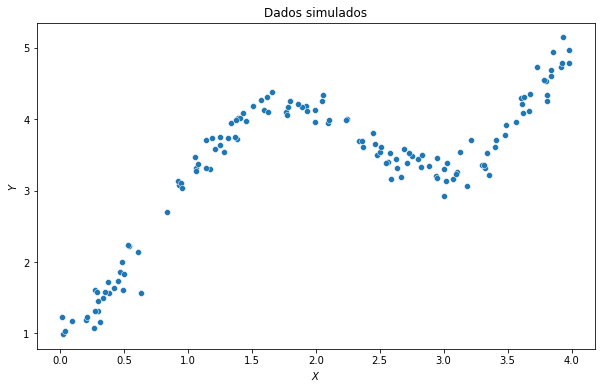

In [16]:
plt.figure(figsize = (10,6))
sns.scatterplot(data = sim_data, x = "X", y = "Y", color = "tab:blue")
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados simulados")
plt.show()

In [17]:
# amostrando aleatoriamente sem reposicao
n_initial = 10
train_idx = np.random.choice(range(X_pool_ex2.shape[0]),
    size = n_initial, replace = False)

s = []
col = []
index = np.arange(0, X_pool_ex2.shape[0])

for i in range(0, X_pool_ex2.shape[0]):
  if i in train_idx:
    col.append('red')
    s.append(50)
  else:
    col.append('black')
    s.append(20)

col_br, col_rand = col.copy(), col.copy()
s_br, s_rand = s.copy(), s.copy()

index = np.delete(index, train_idx)

X_train_ex2 = X_pool_ex2[train_idx]
y_train_ex2 = y_pool_ex2[train_idx]

# reduzindo a pool
X_pool_ex2 = np.delete(X_pool_ex2, train_idx, axis=0)
y_pool_ex2 = np.delete(y_pool_ex2, train_idx)

In [18]:
# iniciando os modelos
reg_mod = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = bias_reduction,
                     X_training = X_train_ex2, y_training = y_train_ex2)

reg_mod_random = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = random_sampling,
                     X_training = X_train_ex2, y_training = y_train_ex2)

In [19]:
from sklearn.metrics import mean_squared_error
n_queries = 20
list_br = laco_modelo(n_queries, reg_mod, 
                          X_pool_ex2, y_pool_ex2, X_test_ex2, y_test_ex2,
                          trace = True, col = col_br, s = s_br, index = index)
list_rand = laco_modelo(n_queries, reg_mod_random, X_pool_ex2, 
                        y_pool_ex2, X_test_ex2, y_test_ex2, trace = True, 
                        col = col_rand, s = s_rand, index = index)

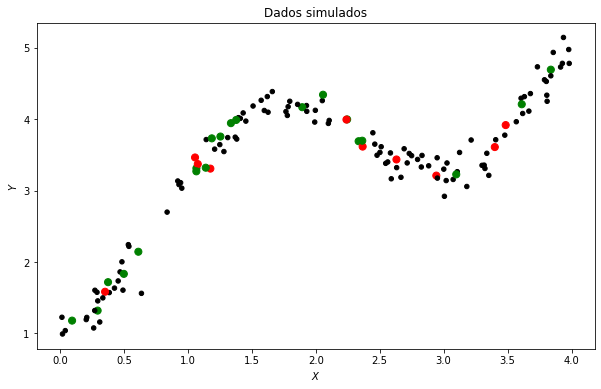

In [20]:
plt.figure(figsize = (10,6))
plt.scatter(x = sim_data.iloc[:,0].values, y = sim_data.iloc[:,1].values, 
                color = list_br[1], s = list_br[2])
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados simulados")
plt.show()

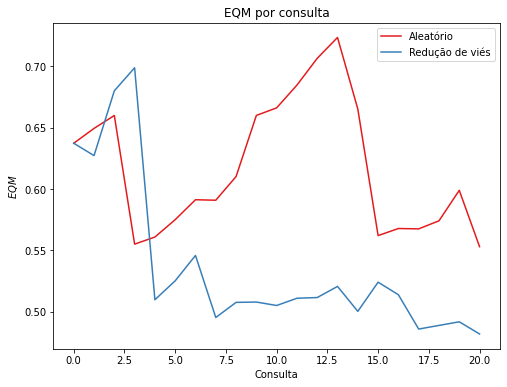

In [21]:
queries = np.arange(0, 21)
plt.figure(figsize = (8, 6))
plt.plot(queries, np.array(list_rand[0]), label = "Aleatório")
plt.plot(queries, np.array(list_br[0]), label = "Redução de viés")
plt.xlabel(r"Consulta")
plt.ylabel(r"$EQM$")
plt.title("EQM por consulta")
plt.legend()
plt.savefig(f"{images_dir}/eqm_por_consulta_reg_nao_lin.pdf")
plt.show()

# Simulações: Testando diferentes combinações de modelos e comparando com amostragem aleatória

Testando as diferentes combinações dois a dois sugeridas pelo professor:


*   Modelo de treino: RL, KNN, RF
*   Modelo de validação: RL, KNN, RF



In [22]:
# importando os modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# fazendo todas as combinacoes 2 a 2
# array de modelos
mods = np.array([LinearRegression(), 
                 RandomForestRegressor(), 
                 KNeighborsRegressor()])
string_mods = np.array(["LR", "RFR", "KNR"])
mesh = np.array(np.meshgrid(mods, mods)).T.reshape(-1, 2)

## BD simulado linear

Amostra de treino inicial fixada anteriormente

In [ ]:
n = 30
np.random.seed(1750)
dici_lin = mse_comb(n_queries = n, X_train = X_train_lin, y_train = y_train_lin, 
                    X_pool = X_pool_lin, y_pool = y_pool_lin, X_test = X_test_lin, y_test = y_test_lin, 
                    mods_list = mods)

In [ ]:
sim_lin = create_sim_data(dici_lin)

In [ ]:
sim_lin

Plotando

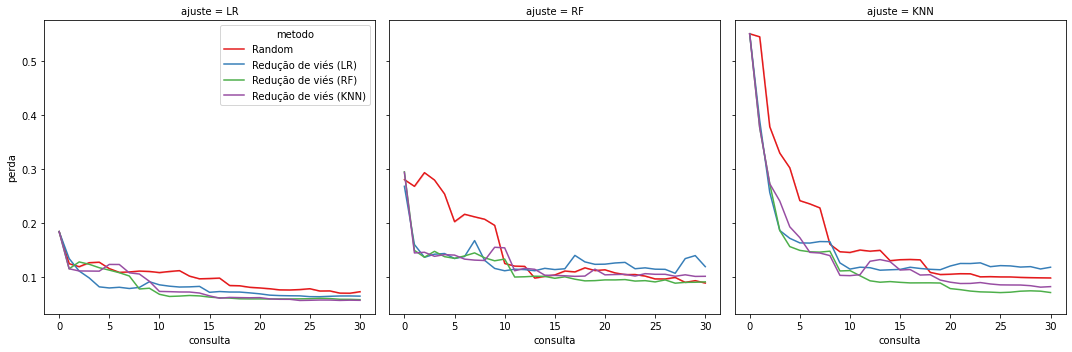

In [ ]:
g = sns.FacetGrid(sim_lin, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend(loc = "upper right")
g.set_ylabels("perda")
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_1_all_comb.pdf")
plt.show()

## BD simulado não linear

Gerando varias amostras:

In [ ]:
X_ex2, y_ex2 = reg_ex2()
X_pool_ex2, X_test_ex2, y_pool_ex2, y_test_ex2 = train_test_split(X_ex2.reshape(-1, 1), y_ex2, test_size = 0.2, random_state=42)

amostras = []
n_amostra = 30
sementes = gera_semente(seed = 850, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex2, y_pool_ex2, seed = sementes[i]))
np.random.seed(450)

In [ ]:
n = 30
dici_ex2 = []
for i in range(n_amostra):
  dici_conj = amostras[i]
  dici_ex2.append(mse_comb(n_queries = n, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test_ex2, 
                    y_test = y_test_ex2, 
                    mods_list = mods))

In [ ]:
dfs = []
for i in range(len(sementes)):
  temp_data = create_sim_data(dici_ex2[i])
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  dfs.append(temp_data)

df = pd.concat(dfs, axis=0, ignore_index=True)
# sim_ex2 = create_sim_data(dici_ex2)
sim_ex2 = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'ajuste': 'first', 'metodo': 'first'})

<Figure size 864x576 with 0 Axes>

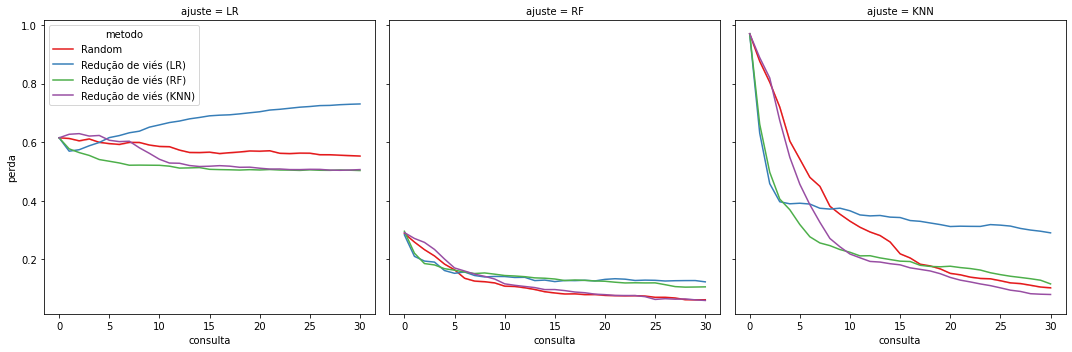

In [ ]:
plt.figure(figsize = (12, 8))
g = sns.FacetGrid(sim_ex2, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend()
g.set_ylabels("perda")
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_2_all_comb.pdf")
plt.show()

In [ ]:
dfs = []
for i in range(len(sementes)):
  temp_data = create_sim_data(dici_ex2[i])
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  dfs.append(temp_data)

df = pd.concat(dfs, axis=0, ignore_index=True)
# sim_ex2 = create_sim_data(dici_ex2)
sim_ex2 = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'ajuste': 'first', 'metodo': 'first'})

In [ ]:
sim_ex2

<Figure size 864x576 with 0 Axes>

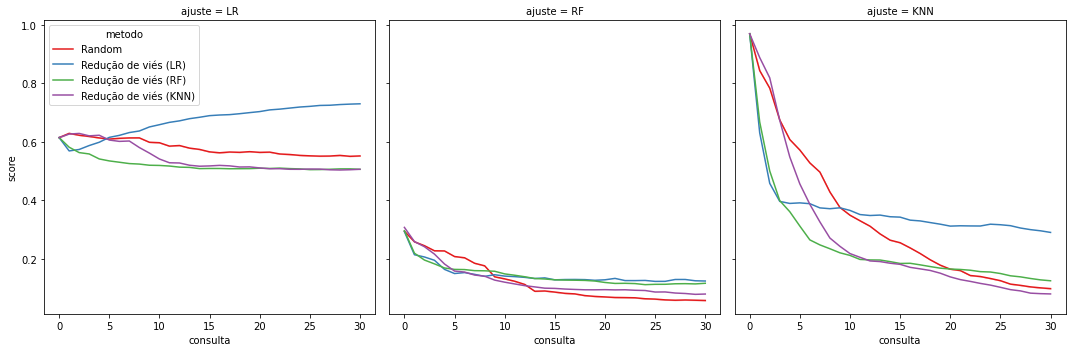

In [ ]:
plt.figure(figsize = (12, 8))
g = sns.FacetGrid(sim_ex2, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend()
plt.tight_layout()
# plt.savefig(f"{images_dir}/eqm_por_consulta_sim_2_all_comb.pdf")
plt.show()

## BD simulado não linear heterocedastico

In [ ]:
# gerando de uma regressao nao linear
np.random.seed(1200)
n = 200
X = np.random.uniform(low=0, high = 4, size = n)

# gerando os y por uma regressao linear
beta_0 = 1
beta_1 = 0.75
y = beta_0 + beta_1 * X + 2*(np.sin(X)**2) + np.random.normal(loc = 0, scale = np.round(X, decimals = 1)/4, size = n)

# funcao 
def reg_ex3(n = 200, beta_0 = 1, beta_1 = 0.75, random_seed = 1200):
  X = np.random.uniform(low=0, high = 4, size = n)
  y = beta_0 + beta_1 * X + 2*(np.sin(X)**2) + np.random.normal(loc = 0, 
                                                                scale = np.round(X, decimals = 1)/4, size = n)
  return [X,y]

# teste para ver desempenho depois
X_pool_ex3, X_test_ex3, y_pool_ex3, y_test_ex3 = train_test_split(X.reshape(-1, 1), y, test_size = 0.3, random_state=42)

ex3_data = pd.DataFrame(data = {'X' : X_pool_ex3.ravel(),
                                'Y' : y_pool_ex3})

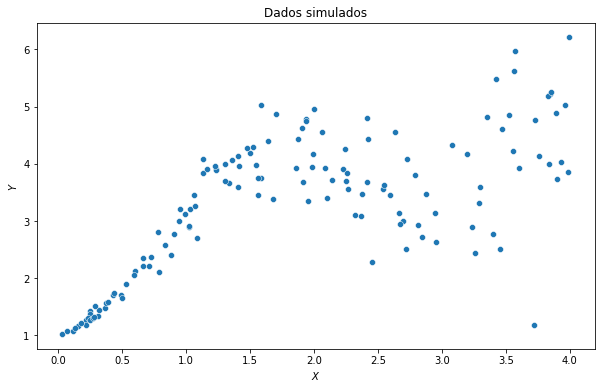

In [ ]:
plt.figure(figsize = (10,6))
sns.scatterplot(data = ex3_data, x = "X", y = "Y", color = "tab:blue")
plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.title("Dados simulados")
plt.show()

In [ ]:
dict_ex3 = prepare_train(X_pool_ex3, y_pool_ex3, seed = 850)

In [ ]:
n = 30
dici_ex3 = mse_comb(n_queries = n, X_train = dict_ex3["X_train"], y_train = dict_ex3["y_train"], 
                    X_pool = dict_ex3["X_pool"], y_pool = dict_ex3["y_pool"], X_test = X_test_ex3, y_test = y_test_ex3, 
                    mods_list = mods, seed = 2750)

In [ ]:
sim_ex3 = create_sim_data(dici_ex3)

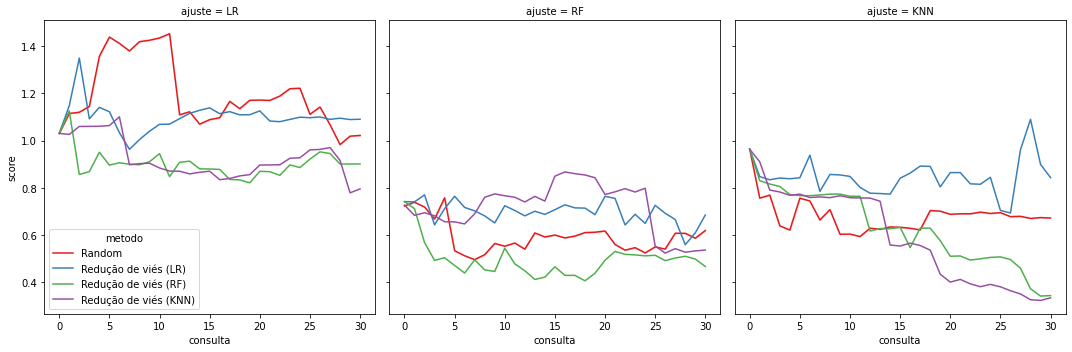

In [ ]:
g = sns.FacetGrid(sim_ex3, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend()
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_3_all_comb.pdf")
plt.show()

Como temos muitas flutações é interessante fazer a média de varias sementes

In [ ]:
n = 30
seed_master = 1500
nrand = 200
np.random.seed(seed_master)
seeds = np.random.choice(np.arange(0, 5500), size = nrand)
sim_data = []

for i in range(nrand):
  dici = mse_comb(n_queries = n, X_train = dict_ex3["X_train"], y_train = dict_ex3["y_train"], 
                    X_pool = dict_ex3["X_pool"], y_pool = dict_ex3["y_pool"], X_test = X_test_ex3, y_test = y_test_ex3, 
                    mods_list = mods, seed = seeds[i])
  temp_data = create_sim_data(dici)
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  sim_data.append(temp_data)

df = pd.concat(sim_data, axis=0, ignore_index=True)

In [ ]:
df_ex4 = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'ajuste': 'first', 'metodo': 'first'})

In [ ]:
df_ex4

,ID,score,consulta,ajuste,metodo
0,0,1.030341,0,LR,Random
1,1,1.026653,1,LR,Random
2,2,1.028279,2,LR,Random
3,3,1.027575,3,LR,Random
4,4,1.024719,4,LR,Random
...,...,...,...,...,...
553,553,0.365137,26,KNN,Redução de viés (KNN)
554,554,0.351398,27,KNN,Redução de viés (KNN)
555,555,0.327059,28,KNN,Redução de viés (KNN)
556,556,0.323909,29,KNN,Redução de viés (KNN)


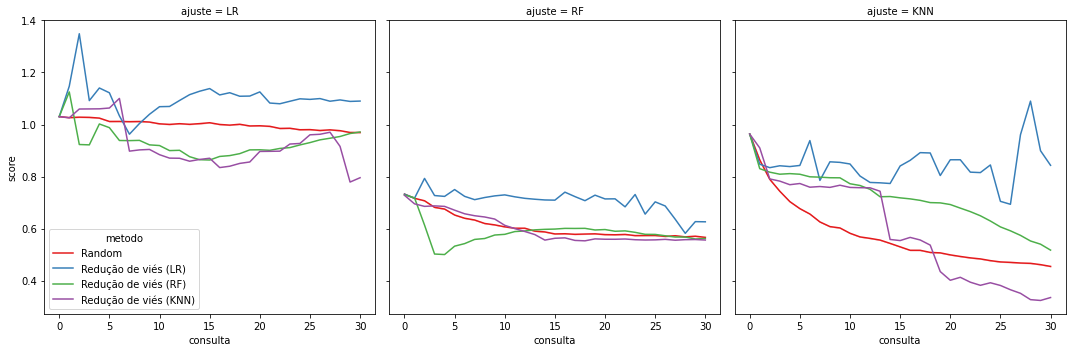

In [ ]:
g = sns.FacetGrid(df_ex4, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend()
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_4_all_comb.pdf")
plt.show()

Mudando as amostras de treino

In [ ]:
# gerando varias amostras de treinamento
X_ex3, y_ex3 = reg_ex3()
X_pool_ex3, X_test_ex3, y_pool_ex3, y_test_ex3 = train_test_split(X_ex3.reshape(-1, 1), y_ex3, test_size = 0.2, random_state=42)

n_amostra = 30
sementes_amostra = gera_semente(seed = 3250, reps = n_amostra)
amostras = []
for i in range(n_amostra):
  amostras.append(prepare_train(X_pool_ex3, y_pool_ex3, seed = sementes_amostra[i]))
np.random.seed(650)

In [ ]:
n = 30
sim_data = []

for i in range(n_amostra):
  dict_ex3 = amostras[i]
  dici = mse_comb(n_queries = n, X_train = dict_ex3["X_train"], y_train = dict_ex3["y_train"], 
                    X_pool = dict_ex3["X_pool"], y_pool = dict_ex3["y_pool"], X_test = X_test_ex3, y_test = y_test_ex3, 
                    mods_list = mods)
  temp_data = create_sim_data(dici)
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  sim_data.append(temp_data)

df = pd.concat(sim_data, axis=0, ignore_index=True)
df_ex4_2 = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'ajuste': 'first', 'metodo': 'first'})

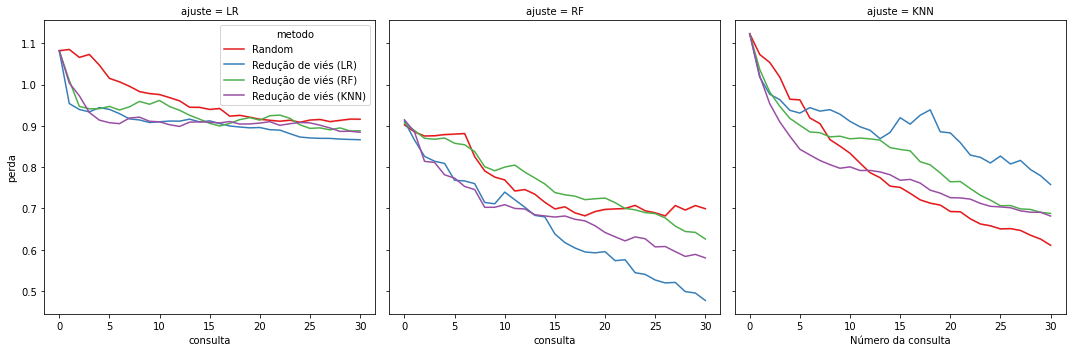

In [ ]:
g = sns.FacetGrid(df_ex4_2, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend()
g.set_ylabels("perda")
plt.xlabel("Número da consulta")
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_4_all_comb_2.pdf")
plt.show()

## Gráfico ilustrando a nossa estratégia:

In [23]:
X_pool_ex2 < 1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [

In [24]:
X_pool_ex2.shape[0]

130

In [28]:
if X_pool_ex2[1, ] > 1:
  print("a")

a


In [29]:
np.random.seed(750)
n_initial = 10
train_idx = np.random.choice([i for i in range(X_pool_ex2.shape[0]) if X_pool_ex2[i, ] < 1 or X_pool_ex2[i, ] > 3],
    size = n_initial, replace = False)

In [38]:
# simulacao nao linear usando como regressor na validação o RF
# amostra e vetores coloridos
# dict_fig = prepare_train(X_pool_ex2, y_pool_ex2, seed = 750, colorize = True)
# X_pool_fig, X_train_fig = dict_fig["X_pool"], dict_fig["X_train"]
# y_pool_fig, y_train_fig = dict_fig["y_pool"], dict_fig["y_train"]
# colors, sizes, index = dict_fig["color"], dict_fig["size"], dict_fig["index"]

# amostra inicial viesada
np.random.seed(750)
n_initial = 10
train_idx = np.random.choice([i for i in range(X_pool_ex2.shape[0]) if X_pool_ex2[i, ] < 1 or X_pool_ex2[i, ] > 3],
    size = n_initial, replace = False)

s = []
col = []
index = np.arange(0, X_pool_ex2.shape[0])

for i in range(0, X_pool_ex2.shape[0]):
  if i in train_idx:
    col.append('red')
    s.append(50)
  else:
    col.append('black')
    s.append(20)

col_br = col.copy()
s_br = s.copy()

index = np.delete(index, train_idx)

X_train_fig = X_pool_ex2[train_idx]
y_train_fig = y_pool_ex2[train_idx]

# reduzindo a pool
X_pool_ex2_fig = np.delete(X_pool_ex2, train_idx, axis=0)
y_pool_ex2_fig = np.delete(y_pool_ex2, train_idx)

# laco do modelo armazenando numa lista as cores e 
def laco_modelo_z_grid(n_queries, modelo, X_pool, y_pool, X_grid,
            col, s, index, **fit_kwargs):
  X_pool_c, y_pool_c = np.copy(X_pool), np.copy(y_pool)
  cols = [col.copy()]
  size = [s.copy()]
  z = [z_value(modelo, X_grid, **fit_kwargs)]
  preds = [modelo.predict(X_grid)]
  # lasso do aprendizado ativo:
  for i in range(n_queries):
    query_idx, query_instance = modelo.query(X_pool_c, **fit_kwargs)
    X_sel, y_sel = X_pool_c[query_idx].reshape(1, -1), y_pool_c[query_idx].reshape(1, )
    modelo.teach(X = X_sel, y = y_sel)
    X_pool_c, y_pool_c = np.delete(X_pool_c, query_idx, axis=0), np.delete(y_pool_c, query_idx)
    col[index[query_idx]] = 'green'
    s[index[query_idx]] = 50
    index = np.delete(index, query_idx)
    if i in [4, 14, 29]:
      cols.append(col.copy())
      size.append(s.copy())
      z.append(z_value(modelo, X_grid))
      preds.append(modelo.predict(X_grid))
  return [cols, size, z, preds]

def z_value(regressor, X, valid_regressor = KNeighborsRegressor(), k = 2, random_state = 99):
  # splitting into two folds:
  kf = KFold(n_splits = k, random_state = random_state, shuffle = True)
  # obtaining labeled data by regressor
  X_labeled, y_labeled = regressor.X_training, regressor.y_training

  errors = np.zeros((X.shape[0], k))
  # K-fold loop
  i = 0
  for train_idx, test_idx in kf.split(X_labeled):
    X_train, X_test = X_labeled[train_idx], X_labeled[test_idx]
    y_train, y_test = y_labeled[train_idx], y_labeled[test_idx]
    # first, fitting the current training data
    # cloning regressor
    train_learner = clone(regressor.estimator)
    train_learner.fit(X = X_train, y = y_train)

    # now obtaining Z
    z = (y_test - train_learner.predict(X_test))**2

    # fitting the regression on z
    valid_learner = clone(valid_regressor)
    valid_learner.fit(X = X_test, y = z)

    # now obtaining the errors for each observation in the pool
    errors[:, i] = valid_learner.predict(X)
    i += 1
  
  # obtaining scores by computing the row-wise means of errors
  scores = errors.mean(axis=1)
  return scores

In [39]:
X_grid = np.linspace(0, 4, 500)
n_queries = 30

# definindo modelo
reg_mod = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = bias_reduction,
                     X_training = X_train_fig, y_training = y_train_fig)

medidas_fig_rf = laco_modelo_z_grid(n_queries, reg_mod,
        X_pool_ex2_fig.copy(), y_pool_ex2_fig.copy(), X_grid.reshape(-1, 1), 
        col_br.copy(), s_br.copy(), index.copy(), valid_regressor = RandomForestRegressor())

reg_mod = ActiveLearner(estimator = LinearRegression(),
                     query_strategy = bias_reduction,
                     X_training = X_train_fig, y_training = y_train_fig)

medidas_fig_knn = laco_modelo_z_grid(n_queries, reg_mod,
        X_pool_ex2_fig.copy(), y_pool_ex2_fig.copy(), X_grid.reshape(-1, 1), 
        col_br.copy(), s.copy(), index.copy())

Figura para o random forest

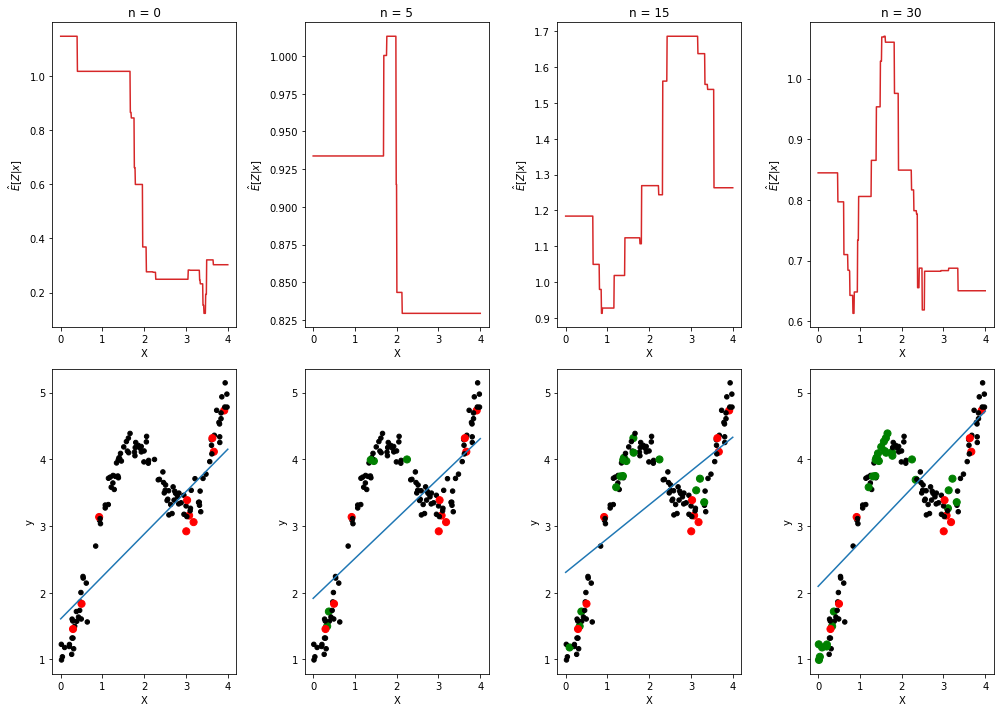

In [40]:
fig, axes = plt.subplots(2, 4, figsize = (14, 10))
count = 0
n = [0, 5, 15, 30]
for cor, size, z, preds, ax in zip(np.tile(medidas_fig_rf[0], (2,1)),
                            np.tile(medidas_fig_rf[1], (2,1)),
                            np.tile(medidas_fig_rf[2], (2,1)), 
                            np.tile(medidas_fig_rf[3], (2,1)),
                            axes.flat):
  if count <= 3:
    ax.plot(X_grid, z, c = "tab:red")
    ax.set_title("n = {}".format(n[count]))
    ax.set_xlabel("X")
    ax.set_ylabel(r"$\hat{E} [Z| x]$")
  else:
    ax.scatter(X_pool_ex2, y_pool_ex2, s = size, c = cor)
    ax.plot(X_grid, preds, c = "tab:blue")
    ax.set_xlabel("X")
    ax.set_ylabel("y")
  count += 1

plt.tight_layout()
# plt.savefig(f"{images_dir}/z_grid_exemplo_rf.pdf")
plt.show()

Figura para o KNN como regressor de validação

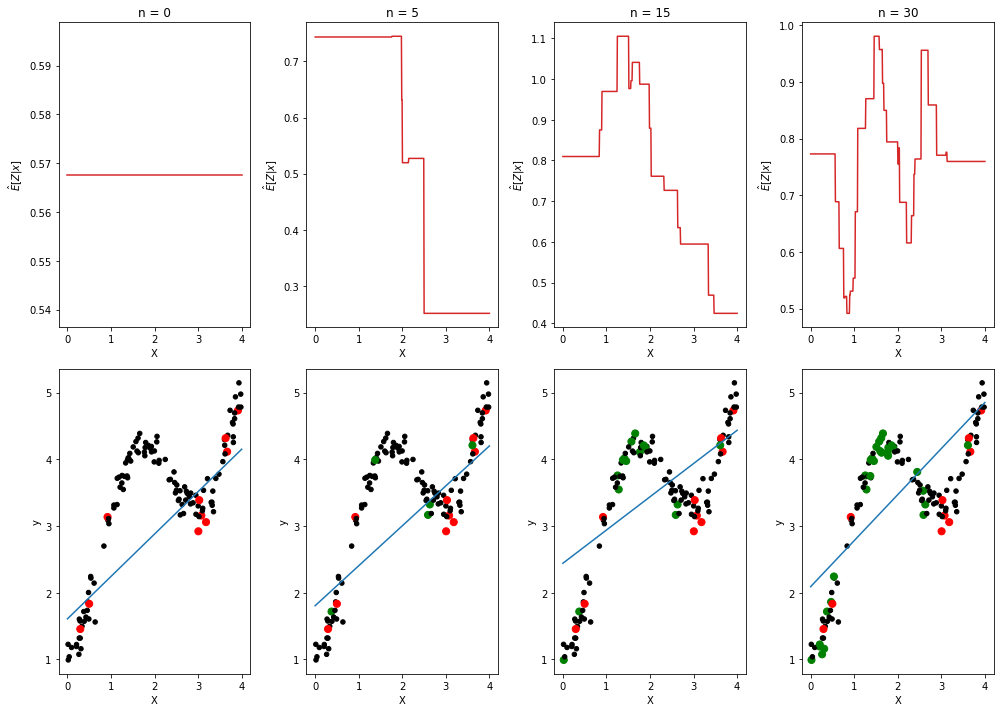

In [41]:
fig, axes = plt.subplots(2, 4, figsize = (14, 10))
count = 0
n = [0, 5, 15, 30]
for cor, size, z, preds, ax in zip(np.tile(medidas_fig_knn[0], (2,1)),
                            np.tile(medidas_fig_knn[1], (2,1)),
                            np.tile(medidas_fig_knn[2], (2,1)), 
                            np.tile(medidas_fig_knn[3], (2,1)),
                            axes.flat):
  if count <= 3:
    ax.plot(X_grid, z, c = "tab:red")
    ax.set_title("n = {}".format(n[count]))
    ax.set_xlabel("X")
    ax.set_ylabel(r"$\hat{E} [Z| x]$")
  else:
    ax.scatter(X_pool_ex2, y_pool_ex2, s = size, c = cor)
    ax.plot(X_grid, preds, c = "tab:blue")
    ax.set_xlabel("X")
    ax.set_ylabel("y")
  count += 1

plt.tight_layout()
plt.savefig(f"{images_dir}/z_grid_exemplo_knn.pdf")
plt.show()

## Dados de alta dimensão

Gerando agora dados de alta dimensão para os 3 diferentes dados que simulamos:

### Dados lineares

In [ ]:
# funcao que adiciona ruido na pool e treino
def add_noise(X, nfeatures = 30, sd = 0.5, mu = 2, seed = 250):
  np.random.seed(seed)
  noise_mat = np.random.normal(size = (X.shape[0], nfeatures), loc = mu, scale = sd)
  return np.hstack((X, noise_mat))

In [ ]:
X_ex1, y_ex1 = reg_lin()
X_noise_1 = add_noise(X_ex1.reshape(-1, 1))
X_pool_ex1, X_test_ex1, y_pool_ex1, y_test_ex1 = train_test_split(X_noise_1, 
                                                                  y_ex1, test_size = 0.2, random_state=42)

In [ ]:
amostras = []
n_amostra = 30
sementes = gera_semente(seed = 485, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex1, y_pool_ex1, seed = sementes[i]))
np.random.seed(950)

Testando apenas uma amostra primeiro para averiguar tempo de execução

In [ ]:
from sklearn.linear_model import Lasso
mods = np.array([Lasso(), 
                 RandomForestRegressor(), 
                 KNeighborsRegressor()])
string_mods = np.array(["L", "RFR", "KNR"])
mesh = np.array(np.meshgrid(mods, mods)).T.reshape(-1, 2)

In [ ]:
n = 30
sim_data = []

for i in range(n_amostra):
  dict_ex1_dim = amostras[i]
  dici = mse_comb(n_queries = n, X_train = dict_ex1_dim["X_train"], y_train = dict_ex1_dim["y_train"], 
                    X_pool = dict_ex1_dim["X_pool"], y_pool = dict_ex1_dim["y_pool"], 
                  X_test = X_test_ex1, y_test = y_test_ex1, 
                    mods_list = mods)
  temp_data = create_sim_data(dici)
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  sim_data.append(temp_data)

df = pd.concat(sim_data, axis=0, ignore_index=True)
df_ex1_dim = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'ajuste': 'first', 'metodo': 'first'})

In [ ]:
df_ex1_dim = df_ex1_dim.replace({"L": "Lasso"}, regex = True)

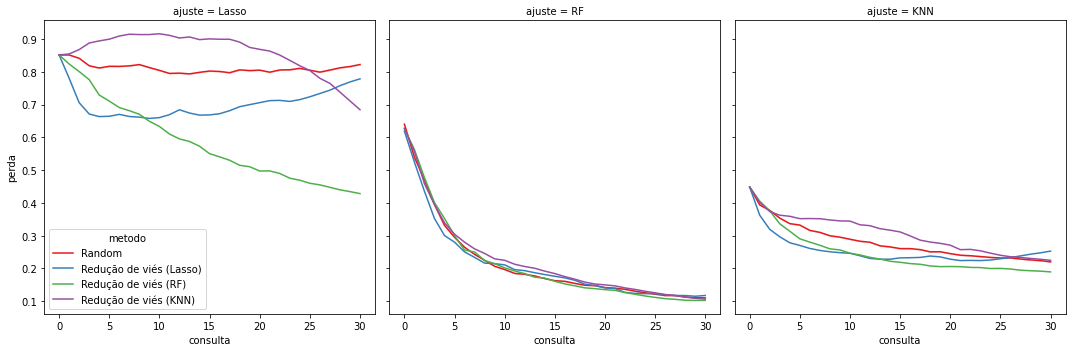

In [ ]:
g = sns.FacetGrid(df_ex1_dim, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.set_ylabels("perda")
g.add_legend()
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_1_dim_all_comb.pdf")
plt.show()


### Dados não lineares


In [ ]:
X_ex2, y_ex2 = reg_ex2()
X_noise_2 = add_noise(X_ex2.reshape(-1, 1))
X_pool_ex2, X_test_ex2, y_pool_ex2, y_test_ex2 = train_test_split(X_noise_2, 
                                                                  y_ex2, test_size = 0.2, random_state=42)

amostras = []
n_amostra = 30
sementes = gera_semente(seed = 850, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex2, y_pool_ex2, seed = sementes[i]))
np.random.seed(750)

In [ ]:
n = 30
sim_data = []

for i in range(n_amostra):
  dict_ex2_dim = amostras[i]
  dici = mse_comb(n_queries = n, X_train = dict_ex2_dim["X_train"], y_train = dict_ex2_dim["y_train"], 
                    X_pool = dict_ex2_dim["X_pool"], y_pool = dict_ex2_dim["y_pool"], 
                  X_test = X_test_ex2, y_test = y_test_ex2, 
                    mods_list = mods)
  temp_data = create_sim_data(dici)
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  sim_data.append(temp_data)

df = pd.concat(sim_data, axis=0, ignore_index=True)
df_ex2_dim = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'ajuste': 'first', 'metodo': 'first'})

In [ ]:
 df_ex2_dim = df_ex2_dim.replace({"L": "Lasso"}, regex = True)

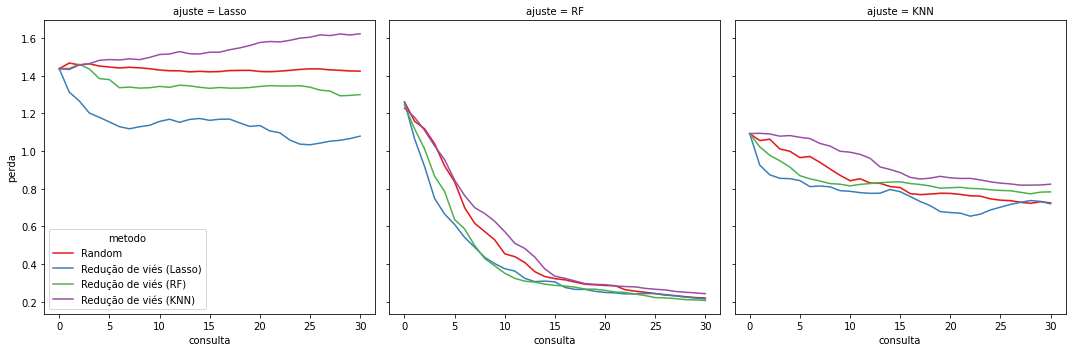

In [ ]:
g = sns.FacetGrid(df_ex2_dim, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5) 
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.set_ylabels("perda")
g.add_legend()
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_2_dim_all_comb.pdf")
plt.show()

### Dados não lineares heterocedasticos

In [ ]:
X_ex3, y_ex3 = reg_ex3()
X_noise_3 = add_noise(X_ex3.reshape(-1, 1))
X_pool_ex3, X_test_ex3, y_pool_ex3, y_test_ex3 = train_test_split(X_noise_3, 
                                                                  y_ex3, test_size = 0.2, random_state=42)

amostras = []
n_amostra = 30
sementes = gera_semente(seed = 650, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex3, y_pool_ex3, seed = sementes[i]))
np.random.seed(750)

In [ ]:
n = 30
sim_data = []

for i in range(n_amostra):
  dict_ex3_dim = amostras[i]
  dici = mse_comb(n_queries = n, X_train = dict_ex3_dim["X_train"], y_train = dict_ex3_dim["y_train"], 
                    X_pool = dict_ex3_dim["X_pool"], y_pool = dict_ex3_dim["y_pool"], 
                  X_test = X_test_ex3, y_test = y_test_ex3, 
                    mods_list = mods)
  temp_data = create_sim_data(dici)
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  sim_data.append(temp_data)

df = pd.concat(sim_data, axis=0, ignore_index=True)
df_ex3_dim = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'ajuste': 'first', 'metodo': 'first'})

In [ ]:
df_ex3_dim = df_ex3_dim.replace({"L": "Lasso"}, regex = True)

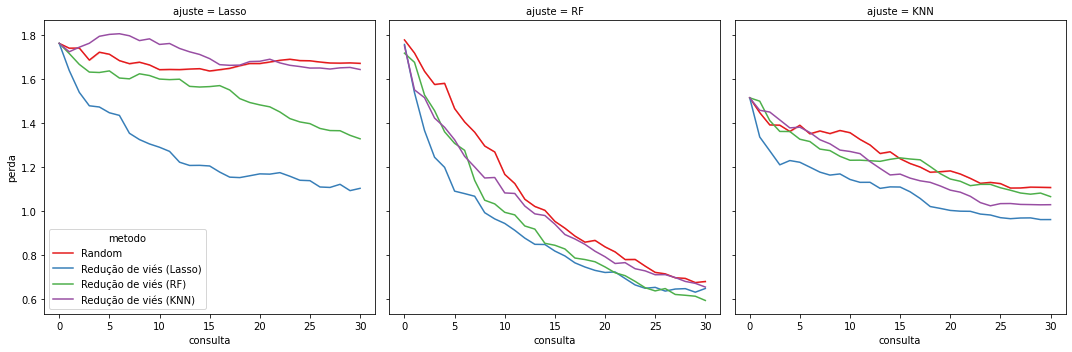

In [ ]:
g = sns.FacetGrid(df_ex3_dim, col = "ajuste", hue = "metodo",
                  despine = False, margin_titles = True, legend_out = False,
                  height = 5)
g.map(sns.lineplot, "consulta", "score")
g.figure.subplots_adjust(wspace=0, hspace=0)
g.add_legend()
g.set_ylabels("perda")
plt.tight_layout()
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_3_dim_all_comb.pdf")
plt.show()

# Simulações: comparando com outros métodos: Uncertainty Sampling, query by comittee e variance reduction 

## Uncertainty sampling

Primeiro comparando com o uncertainty sampling, usando processos gaussianos:

In [26]:
def mse_comp(n_queries, X_train, y_train, X_pool, y_pool,
             X_test, y_test, regressor, our_methods, other_method,
             ensemble = False):
  all_methods = our_methods + other_method
  dici_mse = dict()
  model_list = []
  str1 = ''.join([c for c in str(regressor) if c.isupper()])
  reg_mod_random = ActiveLearner(estimator = regressor,
                     query_strategy = random_sampling,
                     X_training = X_train, y_training = y_train)
  
  list_rand = laco_modelo(n_queries, reg_mod_random, 
                          X_pool, y_pool, X_test, y_test)
  dici_mse[str1 + " " + "Random"] = list_rand
  
  for method in all_methods:
    if method in our_methods:
      reg_mod = ActiveLearner(estimator = regressor,
                     query_strategy = bias_reduction,
                     X_training = X_train, y_training = y_train)
      
      list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test, 
                          valid_regressor = method)
      # string da combinacao
      str2 = ''.join([c for c in str(method) if c.isupper()])
    else:
      reg_mod = ActiveLearner(estimator = regressor,
                     query_strategy = method,
                     X_training = X_train, y_training = y_train)
      list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test)
      
      # string da combinacao
      str2 = ''.join(["Outro"])
    dici_mse[str1 + " " + str2] = list_mse
  return(dici_mse)

Estabelecendo os modelos utilizados:

In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
kernel = RBF(length_scale=1.0) \
         + WhiteKernel(noise_level=1)
our_models = [LinearRegression(), 
                 RandomForestRegressor(), 
                 KNeighborsRegressor()]
other_model = [uncertainty_regression_std]

Gerando dados não lineares homocedasticos por enquanto e ajustando em 30 amostras:

In [ ]:
X_ex2, y_ex2 = reg_ex2()
X_pool_ex2, X_test_ex2, y_pool_ex2, y_test_ex2 = train_test_split(X_ex2.reshape(-1, 1), 
                                                                  y_ex2, test_size = 0.2, random_state=42)

amostras = []
n_amostra = 30
sementes = gera_semente(seed = 950, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex2, y_pool_ex2, seed = sementes[i]))
np.random.seed(850)

In [ ]:
n = 30
dici_ex2_GP = []
for i in range(n_amostra):
  dici_conj = amostras[i]
  dici_ex2_GP.append(mse_comp(n_queries = n, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test_ex2, 
                    y_test = y_test_ex2, 
                    regressor = GaussianProcessRegressor(kernel=kernel),
                    our_methods = our_models,
                    other_method = other_model))

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


In [ ]:
dici_ex2_GP[0].keys()

dict_keys(['GPRRBFWK Random', 'GPRRBFWK LR', 'GPRRBFWK RFR', 'GPRRBFWK KNR', 'GPRRBFWK Outro'])

In [27]:
def create_sim_data_mods(dici_mods, metodo_comp = "Uncertainty"):
  for key in dici_mods.keys():
    mod_string = key.split(" ")
    if mod_string[1] == 'Random':
      df_final = pd.DataFrame({"score" : dici_mods[key],
                      "consulta" : np.arange(0, len(dici_mods[key])),
                      "metodo": np.tile("Random", len(dici_mods[key]))}
                    )
    elif mod_string[1] == "Outro":
      df_temp = pd.DataFrame({"score" : dici_mods[key],
                             "consulta" : np.arange(0, len(dici_mods[key])),
                              "metodo":  np.tile(mod_string[1], len(dici_mods[key]))}
                             )
      df_final = df_final.append(df_temp, ignore_index = True)
    else:
      df_temp = pd.DataFrame({"score" : dici_mods[key],
                             "consulta" : np.arange(0, len(dici_mods[key])),
                              "metodo": np.tile("Redução de viés" + " (" + mod_string[1] + ")", len(dici_mods[key]))}
                             )
      df_final = df_final.append(df_temp, ignore_index = True)
  df_final = df_final.replace({"KNR": "KNN", "RFR": "RF", "Outro":metodo_comp},
                              regex = True)
  return df_final

In [ ]:
dfs = []
for i in range(len(sementes)):
  temp_data = create_sim_data_mods(dici_ex2_GP[i])
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  dfs.append(temp_data)

df = pd.concat(dfs, axis=0, ignore_index=True)
# sim_ex2 = create_sim_data(dici_ex2)
sim_ex2_GP = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'metodo': 'first'})

In [ ]:
sim_ex2_GP

,ID,score,consulta,metodo
0,0,0.938921,0,Random
1,1,0.715170,1,Random
2,2,0.659927,2,Random
3,3,0.645143,3,Random
4,4,0.604571,4,Random
...,...,...,...,...
150,150,0.062326,26,Uncertainty
151,151,0.061599,27,Uncertainty
152,152,0.049861,28,Uncertainty
153,153,0.040065,29,Uncertainty


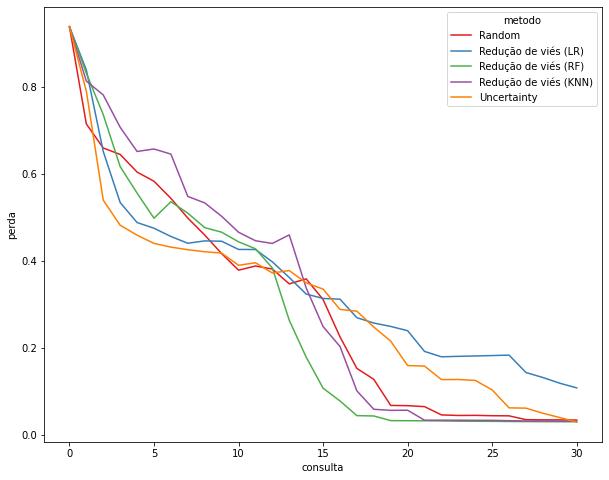

In [ ]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = sim_ex2_GP, x = "consulta", y = "score",
             hue = "metodo")
plt.ylabel("perda")
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_2_GP.pdf")
plt.show()

Gerando dados não lineares homocedasticos com ruido e ajustando em 30 amostras:

In [ ]:
X_ex2, y_ex2 = reg_ex2()
X_noise_2 = add_noise(X_ex2.reshape(-1, 1), nfeatures = 60)
X_pool_ex2, X_test_ex2, y_pool_ex2, y_test_ex2 = train_test_split(X_noise_2, 
                                                                  y_ex2, test_size = 0.2,
                                                                  random_state=42)

amostras = []
n_amostra = 30
sementes = gera_semente(seed = 950, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex2, y_pool_ex2, seed = sementes[i]))
np.random.seed(850)

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.gaussian_process.kernels import DotProduct

our_models = [Lasso(), 
                 RandomForestRegressor(), 
                 KNeighborsRegressor()]

kernel =  RBF(length_scale = 1)

In [ ]:
n = 30
dici_ex2_dim_GP = []
for i in range(n_amostra):
  dici_conj = amostras[i]
  dici_ex2_dim_GP.append(mse_comp(n_queries = n, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test_ex2, 
                    y_test = y_test_ex2, 
                    regressor = GaussianProcessRegressor(kernel=kernel),
                    our_methods = our_models,
                    other_method = other_model))

In [ ]:
dfs = []
for i in range(len(sementes)):
  temp_data = create_sim_data_mods(dici_ex2_dim_GP[i])
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  dfs.append(temp_data)

df = pd.concat(dfs, axis=0, ignore_index=True)
# sim_ex2 = create_sim_data(dici_ex2)
sim_ex2_dim_GP = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'metodo': 'first'})
sim_ex2_dim_GP.replace({"L": "Lasso"},
                              regex = True)

,ID,score,consulta,metodo
0,0,1.110189,0,Random
1,1,1.077846,1,Random
2,2,1.055027,2,Random
3,3,1.019165,3,Random
4,4,1.006563,4,Random
...,...,...,...,...
150,150,0.781838,26,Uncertainty
151,151,0.773891,27,Uncertainty
152,152,0.775390,28,Uncertainty
153,153,0.773678,29,Uncertainty


In [ ]:
sim_ex2_dim_GP = sim_ex2_dim_GP.replace({"L": "Lasso"}, regex = True)

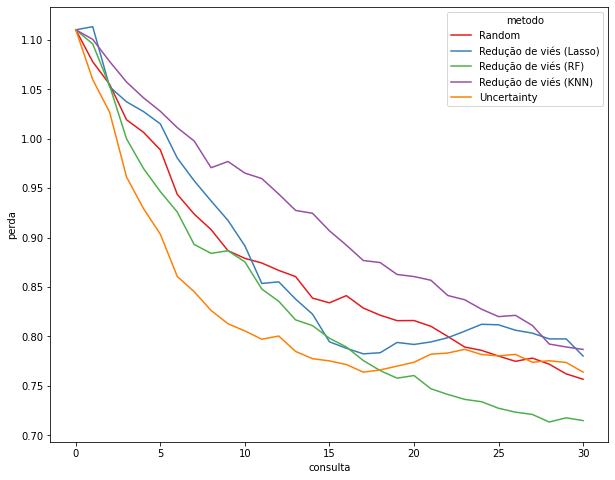

In [ ]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = sim_ex2_dim_GP, x = "consulta", y = "score",
             hue = "metodo")
plt.ylabel("perda")
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_2_dim_GP.pdf")
plt.show()

In [ ]:
X_ex3, y_ex3 = reg_ex3()
X_pool_ex3, X_test_ex3, y_pool_ex3, y_test_ex3 = train_test_split(X_ex3.reshape(-1, 1), 
                                                                  y_ex3, test_size = 0.2, random_state=42)

amostras = []
n_amostra = 30
sementes = gera_semente(seed = 450, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex3, y_pool_ex3, seed = sementes[i]))
np.random.seed(650)

In [26]:
kernel = RBF(length_scale = 1.0) \
         + WhiteKernel(noise_level=1)
         
our_models = [LinearRegression(), 
                 RandomForestRegressor(), 
                 KNeighborsRegressor()]        

In [28]:
n = 30
dici_ex3_GP = []
for i in range(n_amostra):
  dici_conj = amostras[i]
  dici_ex3_GP.append(mse_comp(n_queries = n, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test_ex3, 
                    y_test = y_test_ex3, 
                    regressor = GaussianProcessRegressor(kernel=kernel),
                    our_methods = our_models,
                    other_method = other_model))

NameError: ignored

In [ ]:
dfs = []
for i in range(len(sementes)):
  temp_data = create_sim_data_mods(dici_ex3_GP[i])
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  dfs.append(temp_data)

df = pd.concat(dfs, axis=0, ignore_index=True)
# sim_ex2 = create_sim_data(dici_ex2)
sim_ex3_GP = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'metodo': 'first'})

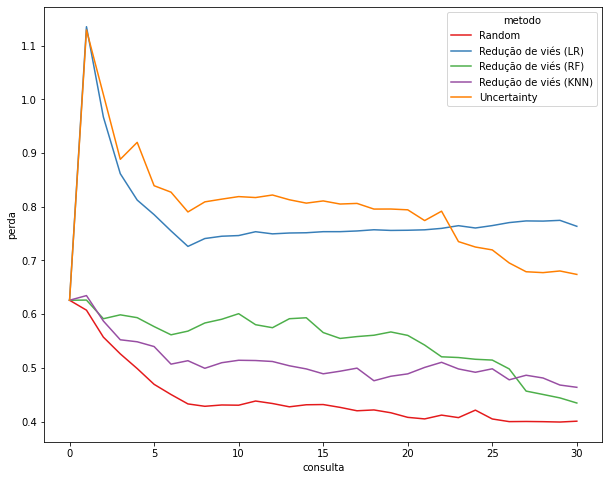

In [ ]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = sim_ex3_GP, x = "consulta", y = "score",
             hue = "metodo")
plt.ylabel("perda")
# plt.savefig(f"{images_dir}/eqm_por_consulta_sim_3_GP.pdf")
plt.show()

Adicionando-se ruido:

In [102]:
X_ex3, y_ex3 = reg_ex3()
X_noise_3 = add_noise(X_ex3.reshape(-1, 1), nfeatures = 60)
X_pool_ex3, X_test_ex3, y_pool_ex3, y_test_ex3 = train_test_split(X_noise_3, 
                                                                  y_ex3, test_size = 0.2,
                                                                  random_state=42)

amostras = []
n_amostra = 35
sementes = gera_semente(seed = 350, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex3, y_pool_ex3, seed = sementes[i]))
np.random.seed(950)

In [103]:
kernel = RBF(length_scale = 1.0) \
         + WhiteKernel(noise_level=1.0)
our_models = [Lasso(), 
                 RandomForestRegressor(), 
                 KNeighborsRegressor()]      

In [104]:
n = 30
dici_ex3_GP_dim = []
for i in range(n_amostra):
  dici_conj = amostras[i]
  dici_ex3_GP_dim.append(mse_comp(n_queries = n, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test_ex3, 
                    y_test = y_test_ex3, 
                    regressor = GaussianProcessRegressor(kernel=kernel),
                    our_methods = our_models,
                    other_method = other_model))

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:4

In [105]:
dfs = []
for i in range(len(sementes)):
  temp_data = create_sim_data_mods(dici_ex3_GP_dim[i])
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  dfs.append(temp_data)

df = pd.concat(dfs, axis=0, ignore_index=True)
# sim_ex2 = create_sim_data(dici_ex2)
sim_ex3_GP_dim = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'metodo': 'first'})

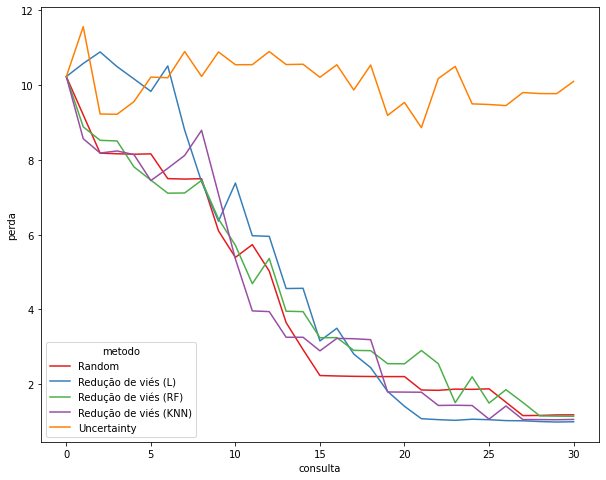

In [112]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = sim_ex3_GP_dim, x = "consulta", y = "score",
             hue = "metodo")
plt.ylabel("perda")
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_3_GP_dim.pdf")
plt.show()

## Query by committee:

Repetindo as mesmas simulações de antes mas com um ensemble de modelo não paramétricos:

In [24]:
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling
def mse_comp_ensemble(n_queries, X_train, y_train, X_pool, y_pool,
             X_test, y_test, methods, our_methods, other_method):
  all_methods = our_methods + other_method
  dici_mse = dict()
  model_list = []
  str1 = "Comite"
  learner_list = [ActiveLearner(
      estimator = method,
      X_training = X_train, y_training = y_train
  ) for method in methods]
  reg_mod_random = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy= random_sampling)
  
  list_rand = laco_modelo(n_queries, reg_mod_random, 
                          X_pool, y_pool, X_test, y_test)
  dici_mse[str1 + " " + "Random"] = list_rand
  committee = CommitteeRegressor(learner_list)
  for method in all_methods:
    if method in our_methods:
      reg_mod = ActiveLearner(estimator = committee,
                     query_strategy = bias_reduction,
                     X_training = X_train, y_training = y_train)
      
      list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test, 
                          valid_regressor = method)
      # string da combinacao
      str2 = ''.join([c for c in str(method) if c.isupper()])
    else:
      learner_list = [ActiveLearner(
        estimator = method,
      X_training = X_train, y_training = y_train
      ) for method in methods]
      reg_mod = CommitteeRegressor(learner_list,
                                   query_strategy = method)
      list_mse = laco_modelo(n_queries, reg_mod, 
                          X_pool, y_pool, X_test, y_test)
      
      # string da combinacao
      str2 = ''.join(["Outro"])
    dici_mse[str1 + " " + str2] = list_mse
  return(dici_mse)

In [25]:
from sklearn.ensemble import BaggingRegressor
methods_list = [RandomForestRegressor(n_estimators = 150, max_depth = 5),
                 BaggingRegressor(n_estimators = 100),
                 KNeighborsRegressor(n_neighbors = 5)]

our_models = [LinearRegression(), 
              RandomForestRegressor(), 
              KNeighborsRegressor()]

other_method = [max_std_sampling]

In [29]:
X_ex2, y_ex2 = reg_ex2()
X_pool_ex2, X_test_ex2, y_pool_ex2, y_test_ex2 = train_test_split(X_ex2.reshape(-1, 1), 
                                                                  y_ex2, test_size = 0.2, random_state=42)

amostras = []
n_amostra = 30
sementes = gera_semente(seed = 1050, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex2, y_pool_ex2, seed = sementes[i]))
np.random.seed(850)

In [28]:
learner_list = [ActiveLearner(
      estimator = method,
      X_training = amostras[0]["X_train"], y_training = amostras[0]["y_train"],
      bootstrap_init=True
  ) for method in methods_list]
committee = CommitteeRegressor(learner_list)
teste = ActiveLearner(estimator = committee,
                     query_strategy = bias_reduction,
                     X_training = amostras[0]["X_train"], y_training = amostras[0]["y_train"],
                      bootstrap_init=True)

In [31]:
n = 30
dici_ex2_comite = []
for i in range(n_amostra):
  dici_conj = amostras[i]
  dici_ex2_comite.append(mse_comp_ensemble(n_queries = n, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test_ex2, 
                    y_test = y_test_ex2,
                    methods = methods_list,
                    our_methods = our_models,
                    other_method = other_method))

In [32]:
dfs = []
for i in range(len(sementes)):
  temp_data = create_sim_data_mods(dici_ex2_comite[i], metodo_comp = "QBC")
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  dfs.append(temp_data)

df = pd.concat(dfs, axis=0, ignore_index=True)
# sim_ex2 = create_sim_data(dici_ex2)
sim_ex2_comite = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'metodo': 'first'})

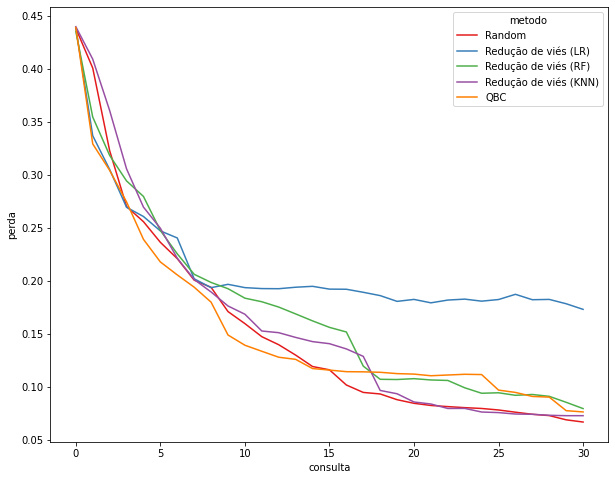

In [34]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = sim_ex2_comite, x = "consulta", y = "score",
             hue = "metodo")
plt.ylabel("perda")
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_2_comite.pdf")
plt.show()

In [27]:
X_ex2, y_ex2 = reg_ex2()
X_noise_2 = add_noise(X_ex2.reshape(-1, 1), nfeatures = 60)
X_pool_ex2, X_test_ex2, y_pool_ex2, y_test_ex2 = train_test_split(X_noise_2, 
                                                                  y_ex2, test_size = 0.2,
                                                                  random_state=42)

amostras = []
n_amostra = 30
sementes = gera_semente(seed = 950, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex2, y_pool_ex2, seed = sementes[i]))
np.random.seed(850)

In [28]:
from sklearn.linear_model import Lasso
our_models = [Lasso(), 
                 RandomForestRegressor(), 
                 KNeighborsRegressor()]

In [29]:
n = 30
dici_ex2_dim_comite = []
for i in range(n_amostra):
  dici_conj = amostras[i]
  dici_ex2_dim_comite.append(mse_comp_ensemble(n_queries = n, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test_ex2, 
                    y_test = y_test_ex2,
                    methods = methods_list,
                    our_methods = our_models,
                    other_method = other_method))

In [30]:
dfs = []
for i in range(len(sementes)):
  temp_data = create_sim_data_mods(dici_ex2_dim_comite[i], metodo_comp = "QBC")
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  dfs.append(temp_data)

df = pd.concat(dfs, axis=0, ignore_index=True)
# sim_ex2 = create_sim_data(dici_ex2)
sim_ex2_dim_comite = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'metodo': 'first'})
sim_ex2_dim_comite = sim_ex2_dim_comite.replace({"L": "Lasso"},
                              regex = True)

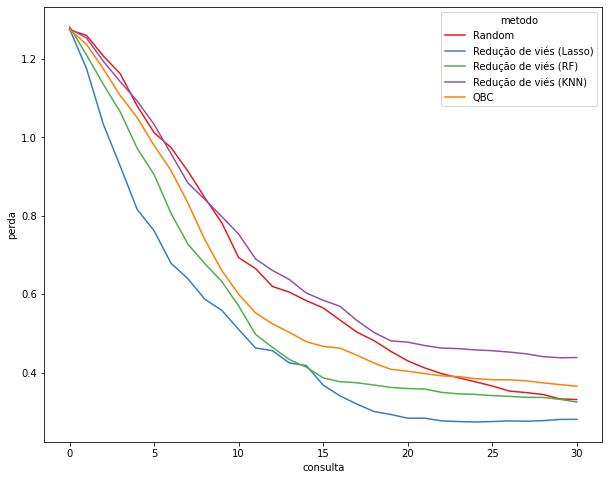

In [32]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = sim_ex2_dim_comite, x = "consulta", y = "score",
             hue = "metodo")
plt.ylabel("perda")
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_2_dim_comite.pdf")
plt.show()

Dados heterocedasticos:

In [28]:
X_ex3, y_ex3 = reg_ex3()
X_pool_ex3, X_test_ex3, y_pool_ex3, y_test_ex3 = train_test_split(X_ex3.reshape(-1, 1), 
                                                                  y_ex3, test_size = 0.2, random_state=42)

amostras = []
n_amostra = 30
sementes = gera_semente(seed = 1250, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex3, y_pool_ex3, seed = sementes[i]))
np.random.seed(850)

In [29]:
from sklearn.ensemble import BaggingRegressor
methods_list = [RandomForestRegressor(n_estimators = 150, max_depth = 5),
                 BaggingRegressor(n_estimators = 100),
                 KNeighborsRegressor(n_neighbors = 5)]

our_models = [LinearRegression(), 
              RandomForestRegressor(), 
              KNeighborsRegressor()]

other_method = [max_std_sampling]

In [30]:
n = 30
dici_ex3_comite = []
for i in range(n_amostra):
  dici_conj = amostras[i]
  dici_ex3_comite.append(mse_comp_ensemble(n_queries = n, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test_ex3, 
                    y_test = y_test_ex3,
                    methods = methods_list,
                    our_methods = our_models,
                    other_method = other_method))

In [31]:
dfs = []
for i in range(len(sementes)):
  temp_data = create_sim_data_mods(dici_ex3_comite[i], metodo_comp = "QBC")
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  dfs.append(temp_data)

df = pd.concat(dfs, axis=0, ignore_index=True)
# sim_ex2 = create_sim_data(dici_ex2)
sim_ex3_comite = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'metodo': 'first'})

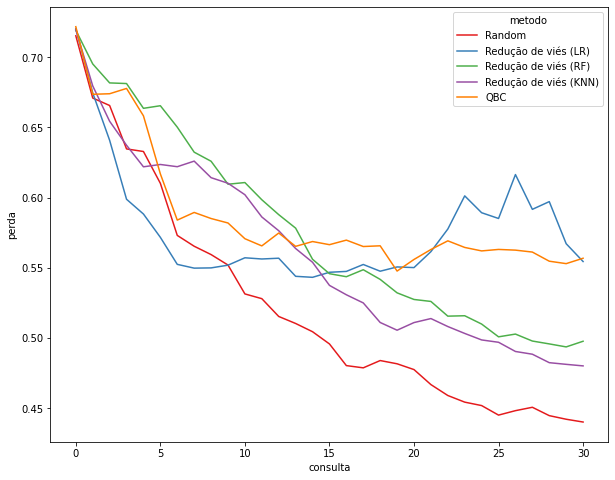

In [33]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = sim_ex3_comite, x = "consulta", y = "score",
             hue = "metodo")
plt.ylabel("perda")
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_3_comite.pdf")
plt.show()

In [34]:
X_ex3, y_ex3 = reg_ex3()
X_noise_3 = add_noise(X_ex3.reshape(-1, 1), nfeatures = 80)
X_pool_ex3, X_test_ex3, y_pool_ex3, y_test_ex3 = train_test_split(X_noise_3, 
                                                                  y_ex3, test_size = 0.2,
                                                                  random_state=42)

amostras = []
n_amostra = 30
sementes = gera_semente(seed = 1350, reps = n_amostra)
for i in range(len(sementes)):
  amostras.append(prepare_train(X_pool_ex3, y_pool_ex3, seed = sementes[i]))
np.random.seed(750)

In [35]:
from sklearn.ensemble import BaggingRegressor
methods_list = [RandomForestRegressor(n_estimators = 150, max_depth = 5),
                 BaggingRegressor(n_estimators = 100),
                 KNeighborsRegressor(n_neighbors = 5)]

our_models = [Lasso(), 
              RandomForestRegressor(), 
              KNeighborsRegressor()]

other_method = [max_std_sampling]

In [36]:
n = 30
dici_ex3_dim_comite = []
for i in range(n_amostra):
  dici_conj = amostras[i]
  dici_ex3_dim_comite.append(mse_comp_ensemble(n_queries = n, X_train = dici_conj["X_train"], y_train = dici_conj["y_train"], 
                    X_pool = dici_conj["X_pool"], y_pool = dici_conj["y_pool"], X_test = X_test_ex3, 
                    y_test = y_test_ex3,
                    methods = methods_list,
                    our_methods = our_models,
                    other_method = other_method))

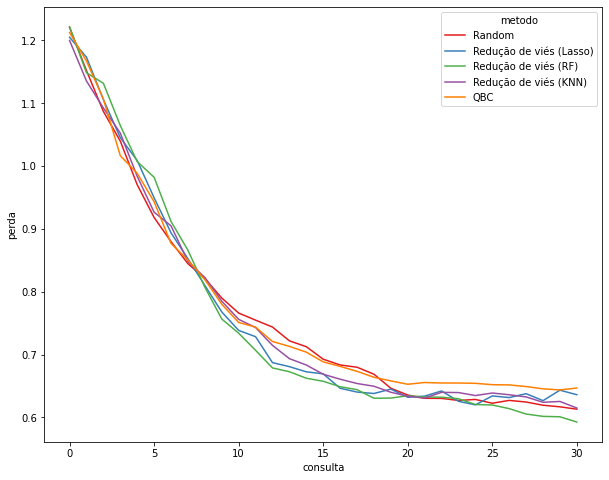

In [38]:
dfs = []
for i in range(len(sementes)):
  temp_data = create_sim_data_mods(dici_ex3_dim_comite[i], metodo_comp = "QBC")
  temp_data = temp_data.assign(ID = np.arange(temp_data.shape[0]))
  dfs.append(temp_data)

df = pd.concat(dfs, axis=0, ignore_index=True)
# sim_ex2 = create_sim_data(dici_ex2)
sim_ex3_comite_dim = df.groupby(['ID'], as_index=False).agg({'score': 'mean', 'consulta' : 'first', 'metodo': 'first'})
sim_ex3_comite_dim = sim_ex3_comite_dim.replace({"L": "Lasso"},
                              regex = True)
# plotting
plt.figure(figsize = (10, 8))
sns.lineplot(data = sim_ex3_comite_dim, x = "consulta", y = "score",
             hue = "metodo")
plt.ylabel("perda")
plt.savefig(f"{images_dir}/eqm_por_consulta_sim_3_dim_comite.pdf")
plt.show()